In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from IPython.display import clear_output, display

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

from pathlib import Path
#dirpath_root = Path('/content/drive/MyDrive/repo/pytorch_test')
dirpath_root = Path().resolve()


In [3]:
fname = 'rates_ws_1_nw_100_wsel_2_npts_5000_rmarg_0.01_seed_113'

data = xr.open_dataset(dirpath_root / 'data' / 'rates_2pop_1mat' / f'{fname}.nc')
print(data.sizes)

# Features
X = data['H']
X = torch.from_numpy(X.values).type(torch.float)

# Target
y = data['R']
y = torch.from_numpy(y.values).type(torch.float)

Frozen({'point': 2736, 'pop': 2})


In [4]:
df_x = pd.DataFrame(X.numpy(), columns=['h1', 'h2'])
df_y = pd.DataFrame(y.numpy(), columns=['r1', 'r2'])
df = pd.concat([df_x, df_y], axis=1)
df

,h1,h2,r1,r2
0,7.532477,3.103267,9.956944,6.746011
1,1.168321,0.123864,4.077924,9.375143
2,5.921931,3.340030,9.959578,3.256295
3,-3.603281,-4.380395,0.305240,7.075720
4,1.513275,1.855762,7.457316,8.820196
...,...,...,...,...
2731,11.554640,12.168859,9.987188,9.987862
2732,11.521655,12.286503,9.986972,9.988559
2733,11.424413,12.399865,9.986319,9.989194
2734,11.403275,12.463993,9.986172,9.989537


In [5]:
df.std(axis=0)

h1    5.504669
h2    5.389411
r1    4.168048
r2    4.448093
dtype: float32

In [6]:
torch.manual_seed(0)

# Split into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f'Train size: {X_train.shape} \nTest size: {X_test.shape}')

Train size: torch.Size([2188, 2]) 
Test size: torch.Size([548, 2])


In [7]:
# Hyper-parameters
HIDDEN_SZ = 32
NLAYERS_HID = 1

n_feat = X.shape[1]
n_out = 2

# Define the model
layers = [nn.Linear(n_feat, HIDDEN_SZ), nn.Tanh()]
for _ in range(NLAYERS_HID):
    layers += [nn.Linear(HIDDEN_SZ, HIDDEN_SZ), nn.Tanh()]
layers += [nn.Linear(HIDDEN_SZ, n_out)]
model = nn.Sequential(*layers).to(device)

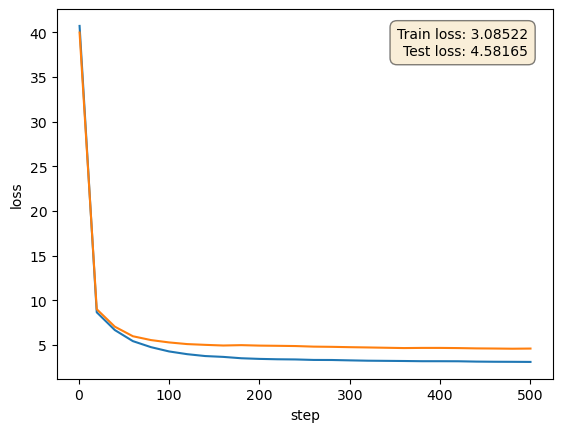

In [8]:
# Hyper-parameters
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 500

n_samples = X_train.shape[0]

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# Loss + optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Here we accumulate losses
train_loss_vec = []
test_loss_vec = []
epochs_vec = []   # for plotting

# Prepare visualization
fig, ax = plt.subplots()
(train_loss_plot,) = ax.plot([], [])
(test_loss_plot,) = ax.plot([], [])
ax.set_xlabel("step"); ax.set_ylabel("loss")
txt = ax.text(0.95, 0.95, "", transform=ax.transAxes, fontsize=10,
              va='top', ha='right',
              bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Training loop
for epoch in range(1, EPOCHS + 1):
    model.train()   # switch to training mode

    train_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= n_samples

    if epoch % 20 == 0 or epoch == 1:
        # Testing
        model.eval()   # switch to evaluation mode
        with torch.inference_mode():
            pred = model(X_test)
            test_loss = loss_fn(pred, y_test)

        # Store the losses
        train_loss_vec.append(train_loss)
        test_loss_vec.append(test_loss.to('cpu'))
        epochs_vec.append(epoch)

        # Visualize loss dynamics
        train_loss_plot.set_data(epochs_vec, train_loss_vec)
        test_loss_plot.set_data(epochs_vec, test_loss_vec)
        ax.relim(); ax.autoscale_view()
        #plt.ylim(0, 2)

        # Add text box with losses
        textstr = 'Train loss: {:.5f}\nTest loss: {:.5f}'.format(train_loss, test_loss)
        txt.set_text(textstr)

        clear_output(wait=True)
        display(fig)

        #print(f'Epoch: {epoch:3d}, '
        #      f'Train loss: {train_loss:.5f} ',
        #      f'Test loss: {test_loss:.5f}', flush=True)

plt.close(fig)

In [9]:
model.eval()
with torch.inference_mode():
    yhat_train = model(X_train.to(device)).cpu().numpy()
    yhat_test = model(X_test.to(device)).cpu().numpy()

X_train = X_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()

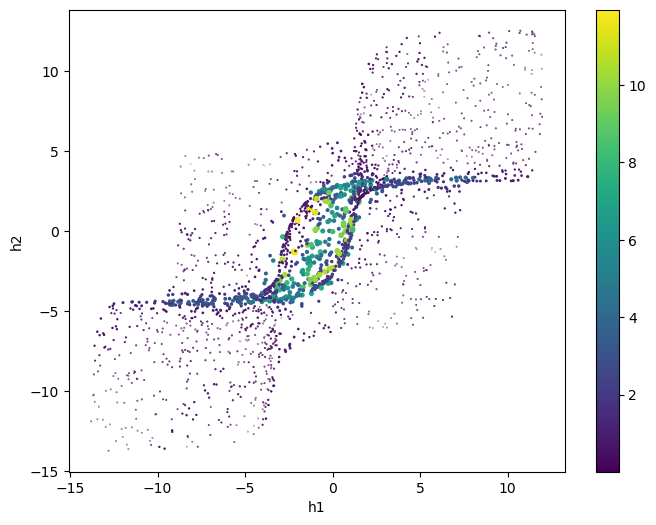

In [23]:
err_train = np.sqrt(np.sum((yhat_train - y_train) ** 2, axis=1))
err_test = np.sqrt(np.sum((yhat_test - y_test) ** 2, axis=1))

#s = 1
s = err_train
c = err_train 

plt.figure(figsize=(8, 6))
#plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
#plt.scatter(y_train[:, 0], y_train[:, 1], s=s, c=c)
#plt.xlabel('r1')
#plt.ylabel('r2')
#plt.colorbar()
#plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], s=s, c=c)
plt.xlabel('h1')
plt.ylabel('h2')
plt.colorbar()
plt.show()